In [5]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

In [6]:
arxiv_api_wrapper = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=arxiv_api_wrapper)

In [7]:
wikipedia_api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=1000)
wikipedia = WikipediaQueryRun(api_wrapper=wikipedia_api_wrapper)

In [45]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = "ReAct_Agent"

In [9]:
from langchain_tavily import TavilySearch

tavily = TavilySearch(
    max_results=5,
    topic="general"
)

In [63]:
## Custom calculation function
def add(a: int, b: int) -> int:
    """
    Add two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The sum of a and b.
    """
    return a + b


def subtract(a: int, b: int) -> int:
    """
    Subtract the second integer from the first.

    Args:
        a (int): The number from which to subtract.
        b (int): The number to subtract.

    Returns:
        int: The difference between a and b.
    """
    return a - b


def multiply(a: int, b: int) -> int:
    """
    Multiply two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """
    return a * b


def divide(a: int, b: int) -> float:
    """
    Divide the first number by the second.

    Args:
        a (int): The dividend.
        b (int): The divisor (must not be zero).

    Returns:
        float: The quotient of a divided by b.

    Raises:
        ZeroDivisionError: If b is zero.
    """
    if b == 0:
        raise ZeroDivisionError("Division by zero is not allowed.")
    return a / b

tools = [arxiv, wikipedia, tavily, add, subtract, multiply, divide]

In [64]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1")
llm_with_multiple_tools = llm.bind_tools(tools=tools)

In [ ]:
## Initiliaze the chat model
from langchain_groq import ChatGroq

llm = ChatGroq(model="qwen/qwen3-32b")
llm_with_multiple_tools = llm.bind_tools(tools=tools)

In [66]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode
from pydantic import BaseModel
from langchain.messages import AnyMessage
from typing import Annotated

class State(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]

In [67]:
def llm_with_tools(state: State):
    return {"messages": [llm_with_multiple_tools.invoke(state.messages)]}

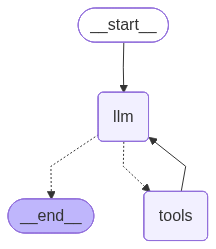

In [68]:
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

builder = StateGraph(State)

## Add node
builder.add_node("llm", llm_with_tools)
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "llm")
builder.add_conditional_edges("llm", tools_condition)
builder.add_edge("tools", "llm")


graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [69]:
from langchain.messages import HumanMessage
msgs = graph.invoke({"messages": HumanMessage(content="Provide me latest news on Iran")})

for msg in msgs["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Provide me latest news on Iran
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_rWKdPba0fMdInnBTbBMIkYHn)
 Call ID: call_rWKdPba0fMdInnBTbBMIkYHn
  Args:
    query: latest news on Iran
    search_depth: advanced
    topic: news
    time_range: week
================================= Tool Message =================================
Name: tavily_search

{"query": "latest news on Iran", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.criticalthreats.org/analysis/iran-update-february-27-2026", "title": "Iran Update, February 27, 2026 | Critical Threats", "content": "Iranian Nuclear Program: The International Atomic Energy Agency (IAEA) cannot verify whether Iran has suspended “all enrichment-related activities,” according", "score": 0.97324073, "raw_content": null}, {"url": "https://www.bbc.com/news/live

In [71]:
from langchain.messages import HumanMessage
msgs = graph.invoke({"messages": HumanMessage(content="Provide top 10 world news. ALong with that do basic maths. What is 2+2 and then multiply the result by 20")})

for msg in msgs["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Provide top 10 world news. ALong with that do basic maths. What is 2+2 and then multiply the result by 20
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_fS42QGub5skyi3zi46v12zGk)
 Call ID: call_fS42QGub5skyi3zi46v12zGk
  Args:
    query: top 10 world news
    search_depth: advanced
    topic: news
  add (call_MQaKwJ9EdHSoi3kQ0qKKcf0O)
 Call ID: call_MQaKwJ9EdHSoi3kQ0qKKcf0O
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: tavily_search

{"query": "top 10 world news", "response_time": 1.23, "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://apnews.com/world-news", "title": "World News: Top & Breaking World News Today | AP News", "content": "[deltaMinutes] mins ago Now     \n4.   ### Attorney general announces indictment against 30 more peop

In [72]:
msgs = graph.invoke({"messages": HumanMessage(content="Do basic maths. What is 2+2 and then multiply the result by 20. And then tell me about Salman Kjan")})

for msg in msgs["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Do basic maths. What is 2+2 and then multiply the result by 20. And then tell me about Salman Kjan
================================== Ai Message ==================================
Tool Calls:
  add (call_UUoMmrqToTa5XTxm8nelq4py)
 Call ID: call_UUoMmrqToTa5XTxm8nelq4py
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4
================================== Ai Message ==================================
Tool Calls:
  multiply (call_rxvgc4AIBECJQiqQB8d8G0PA)
 Call ID: call_rxvgc4AIBECJQiqQB8d8G0PA
  Args:
    a: 4
    b: 20
================================= Tool Message =================================
Name: multiply

80
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_Ex2HYBWmDF2xM3tw6NK1L3zJ)
 Call ID: call_Ex2HYBWmDF2xM3tw6NK1L3zJ
  Args:
    query: Salman Khan
=================

In [74]:
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

builder = StateGraph(State)

## Add node
builder.add_node("llm", llm_with_tools)
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "llm")
builder.add_conditional_edges("llm", tools_condition)
builder.add_edge("tools", "llm")



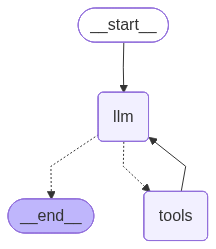

In [77]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph_with_memory = builder.compile(checkpointer=memory)

display(Image(graph_with_memory.get_graph().draw_mermaid_png()))

In [79]:
#Specify the thread
config = {"configurable": {"thread_id": "sam_thread"}}

messages = [HumanMessage(content="Add 13 and 14")]

msgs = graph_with_memory.invoke({"messages": messages}, config=config)

for msg in msgs["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Add 13 and 14
================================== Ai Message ==================================
Tool Calls:
  add (call_wkJLfB9wLx2bmHr9rnNVPKAP)
 Call ID: call_wkJLfB9wLx2bmHr9rnNVPKAP
  Args:
    a: 13
    b: 14
================================= Tool Message =================================
Name: add

27
================================== Ai Message ==================================

The sum of 13 and 14 is 27.


In [80]:

msgs = graph_with_memory.invoke({"messages": HumanMessage("Multiply the result with 9999")}, config=config)

for msg in msgs["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Add 13 and 14
================================== Ai Message ==================================
Tool Calls:
  add (call_wkJLfB9wLx2bmHr9rnNVPKAP)
 Call ID: call_wkJLfB9wLx2bmHr9rnNVPKAP
  Args:
    a: 13
    b: 14
================================= Tool Message =================================
Name: add

27
================================== Ai Message ==================================

The sum of 13 and 14 is 27.
================================ Human Message =================================

Multiply the result with 9999
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Rfg59fnPxsMDsKbiDu9pMqe5)
 Call ID: call_Rfg59fnPxsMDsKbiDu9pMqe5
  Args:
    a: 27
    b: 9999
================================= Tool Message =================================
Name: multiply

269973
================================== Ai Message ================================